In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
from collections import Counter
import scipy.stats as stats
%matplotlib inline

The amount of information is going to be less as the position in the hierarchy increases. And the amount of trust could be random throughout the network.

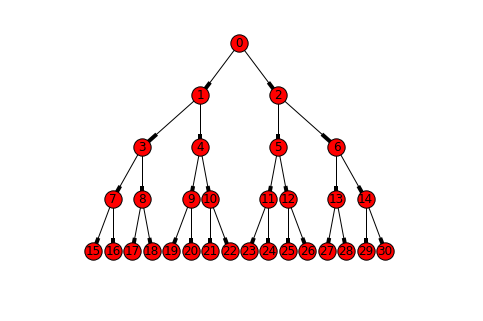

In [2]:
num_levels = 5
num_subordinates = 2
G = nx.DiGraph()
G.add_node(0)

leaf_nodes_last_level = [0]
nodes_in_levels = defaultdict(list)
nodes_in_levels[0] = [0]
levels_of_nodes = dict()
levels_of_nodes[0] = 0

for i in range(1, num_levels):
    #print i, pow(2,i)
    num_nodes_this_level = pow(2,i)
    possible_subordinates = range(G.number_of_nodes(), G.number_of_nodes()+ num_nodes_this_level )
    leaf_nodes_next_level = list(possible_subordinates)
    #print "possible subordinates", possible_subordinates

    while len(leaf_nodes_last_level) > 0:
        current_supervisor = leaf_nodes_last_level.pop(0)
        #print "after popping", leaf_nodes_last_level
        #print "##current supervisor", current_supervisor
        for j in range(num_subordinates):
            current_subordinate = possible_subordinates.pop(0)
            #print "####current subordinate", current_subordinate
            G.add_edge(current_supervisor, current_subordinate)
            #print "i", i
            nodes_in_levels[i].append(current_subordinate)
            levels_of_nodes[current_subordinate] = i
    leaf_nodes_last_level = list(leaf_nodes_next_level)
        
# pos = hierarchy_pos(btree2, 0)
#nx.draw(btree2,pos=nx.draw_networkx(btree2),with_labels=True,arrows=True)
pos=nx.nx_pydot.graphviz_layout(G,prog='dot')
nx.draw(G,pos,with_labels=True,arrows=True)

Our first assumption is that the deeper the level the less the initial information $H$ in the node. And we will distribute the initial $\alpha$ value distributed randomly using a lognormal distributions with parameter $\mu$ and $\sigma$

In [3]:
def sample_h(level, mean_info = 0.7, sd_info = 0.05, dmu = 0.1, constant = False):
    if constant == False:
        ## the distribution will be Truncated between 0 and 1
        lower, upper = 0, 1
        ## The distribution
        mu = mean_info - (dmu * (level-1))
        sigma = sd_info
        X = stats.truncnorm((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)
        s = X.rvs(1)[0]
        return s
    else:
        return mean_info

def sample_alpha(mu = 0.5, sigma = 0.1, constant = False):
    if constant == False:
        ## the distribution will be Truncated between 0 and 1
        lower, upper = 0, 1
        ## The distribution
        X = stats.truncnorm((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)
        s = X.rvs(1)[0]
        return s
    else:
        return mu

def sample_change_in_alpha(mu = 0.1, sigma = 0.01, constant = False):
    if constant == False:
        ## the distribution will be Truncated between 0 and 1
        lower, upper = 0, 1
        ## The distribution
        X = stats.truncnorm((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)
        s = X.rvs(1)[0]
        return s
    else:
        return mu

We do not have any problem assigning H in node 0 as there is no edge pointing towards him. So for mu, dmu * (level -1 ) is not a problem.

In [4]:
nx.get_edge_attributes(G, 'alpha')

{}

In [5]:
nx.get_edge_attributes(G, 'H')

{}

In [6]:
def trust_flow(iteration_count =, orders, mean_alpha  = 0.5, mean_info_higehst_level = 0.2, delta = 0, plot_network = False):
    
    sd_trust = 0.1
    dmu_each_level = mean_info_higehst_level / (num_levels - 1)
    mean_change_in_alpha = 0.05
    sd_change_in_alpha = 0.001

    for edge in G.edges():
        subordinate_node = edge[1]
        current_h = mean_info_higehst_level#sample_h(levels_of_nodes[subordinate_node], mean_info = mean_info_higehst_level, dmu = dmu_each_level)
        current_alpha = mean_alpha#sample_alpha(mean_trust, sd_trust)
        G[edge[0]][edge[1]]['H'] = current_h
        G[edge[0]][edge[1]]['alpha'] = current_alpha
    
    
    all_iterations = dict()
    for it in range(iteration_count):
        ## Order can be -1 or 1
        flips = {1:-1, -1:1}
        order = orders[it]
        print order
        root_node = 0
        bits = dict()
        bits[root_node] = order
        flip_keep = dict()

        for edge in list(nx.bfs_edges(G ,root_node)):
            source_node = edge[0]
            target_node = edge[1]
            source_bit = bits[source_node]
            #print "##", edge, source_bit
            current_alpha = G[source_node][target_node]['alpha']
            current_info = G[source_node][target_node]['H']
            processed_info = current_alpha + current_info * source_bit
            #print "processed_info", processed_info, "delta", delta
            if processed_info >= delta:
                ## Keeping
                #print "Keeping"
                processed_bit = source_bit
                flip_keep[(source_node,target_node)] = 'keep'
            else:
                ## Flipping
                #print "Flipping"
                processed_bit = flips[source_bit]
                flip_keep[(source_node,target_node)] = 'flip'
            bits[target_node] = processed_bit

        ## We are counting the overall outcome in the whole system
        ## We need the good outcomes to be greater than bad outcomes to 
        ## make it a collective good outcome
        collective_outcome = ""

        ##  If its a good outcome:
        ##       if I followed my supervisors order, I trust him more
        ##       if I flipped my supervisors order, I trust him less
        ## If its a bad outcome:
        ##       if I followed my supervisors order, I trust him less
        ##       if I flipped my supervisors order, I trust him more 
        ##           (you can think of it this way, it is a bad outcome
        ##           and I did not abide by his order, and based on my local 
        ##           knowledge, I feel I should have gone with my supervisors
        ##           order)
        if Counter(bits.values())[1] > Counter(bits.values())[-1]:
            collective_outcome = "good"
            print collective_outcome
            for edge, current_alpha in nx.get_edge_attributes(G, 'alpha').items():
                if flip_keep[edge] == "keep":
                ## It was a good outcome and I listened to my supervisor, so I feel he is a person I can trust more
                    #print edge, current_alpha
                    new_alpha = current_alpha + sample_change_in_alpha(mean_change_in_alpha, sd_change_in_alpha)
                    if new_alpha > 1:
                        new_alpha = 1
                    elif new_alpha < 0:
                        new_alpha = 0
                    G[edge[0]][edge[1]]['alpha'] = new_alpha
                else:
                ## It was a good outcome and I did not listen to my supervisor, so I feel he is a person I should trust less, because by not listening to him, I feel that I contributed to the good outcome
                    #print edge, current_alpha
                    new_alpha = current_alpha - sample_change_in_alpha(mean_change_in_alpha, sd_change_in_alpha)
                    if new_alpha > 1:
                        new_alpha = 1
                    elif new_alpha < 0:
                        new_alpha = 0
                    G[edge[0]][edge[1]]['alpha'] = new_alpha
        else:
            collective_outcome = "bad"
            print collective_outcome
            for edge, current_alpha in nx.get_edge_attributes(G, 'alpha').items():
                if flip_keep[edge] == "keep":
                ## It was a bad outcome and I listened to my supervisor, and by listening to him I contributed to the disaster, so I feel he is a person I should trust less
                    #print edge, current_alpha
                    new_alpha = current_alpha - sample_change_in_alpha(mean_change_in_alpha, sd_change_in_alpha)
                    if new_alpha > 1:
                        new_alpha = 1
                    elif new_alpha < 0:
                        new_alpha = 0
                    G[edge[0]][edge[1]]['alpha'] = new_alpha
                else:
                ## It was a bad outcome and I did not listen to my supervisor, so I feel by listening to him I could have averted the disaster, so I feel I should listen to him/ trust him more.
                    #print edge, current_alpha
                    new_alpha = current_alpha + sample_change_in_alpha(mean_change_in_alpha, sd_change_in_alpha)
                    if new_alpha > 1:
                        new_alpha = 1
                    elif new_alpha < 0:
                        new_alpha = 0
                    G[edge[0]][edge[1]]['alpha'] = new_alpha


        all_iterations[it] = dict()
        all_iterations[it]['collective_outcome'] = collective_outcome
        #print collective_outcome
        all_iterations[it]['flip_keep'] = flip_keep
        #print Counter(flip_keep.values())
        all_iterations[it]['bits'] = bits
        #print Counter(bits.values())

        #print nx.get_edge_attributes(G, 'alpha')
        all_iterations[it]['alpha'] = nx.get_edge_attributes(G, 'alpha')

        labels = dict()
        alphas = nx.get_edge_attributes(G, 'alpha')
        Hs = nx.get_edge_attributes(G, 'H')
        for key in G.edges():
            #print key
            current_alpha = round(alphas[key], 1)
            current_H = round(Hs[key], 1)
            labels[key] = (current_alpha, current_H)
        # print labels
        if plot_network == True:
            plt.figure(figsize=(12,10))
            pos=nx.nx_pydot.graphviz_layout(G,prog='dot')
            nx.draw_networkx_edge_labels(G,pos=nx.nx_pydot.graphviz_layout(G,prog='dot'), edge_labels = labels)
            color_map_node = {1:'g', -1:'r'} 
            color_map_edge = {"keep":'g', "flip":'r'} 
            # colors = [G[u][v]['color'] for u,v in edges]
            nx.draw(G,pos, node_color=[color_map_node[bits[node]] for node in G],  edge_color=[color_map_edge[flip_keep[edge]] for edge in G.edges()],with_labels=True,arrows=True)
    return all_iterations

In [32]:
delta = 0.6  ## The higher the delta the more skeptical we are
plot_network = False
mean_alpha = 0.2
mean_info_higehst_level = 0.2
iteration_count = 200
order = -1
p_good_order = 0.2
order_size = iteration_count
binomial_list = np.random.binomial(1,p_good_order,size =order_size)
orders = list()
for i in range(len(binomial_list)):
    if binomial_list[i] == 1:
        orders.append(1)
    else:
        orders.append(-1)



all_iterations = trust_flow(iteration_count = iteration_count, orders = orders, mean_alpha = mean_alpha, mean_info_higehst_level = mean_info_higehst_level,delta = delta, plot_network = plot_network)

-1
bad
-1
bad
-1
bad
-1
bad
-1
good
1
good
-1
bad
-1
bad
-1
bad
-1
good
-1
good
-1
good
-1
good
-1
good
1
good
-1
good
-1
good
-1
good
-1
good
1
bad
-1
good
1
bad
-1
good
-1
good
-1
good
-1
good
1
bad
-1
good
1
bad
1
bad
-1
good
-1
good
-1
good
-1
good
1
bad
-1
good
-1
good
-1
good
-1
good
-1
good
-1
good
-1
good
-1
good
-1
good
-1
good
-1
good
-1
good
-1
good
1
bad
-1
good
-1
good
-1
good
1
bad
-1
good
-1
good
-1
good
-1
good
-1
good
1
bad
1
bad
-1
good
-1
good
-1
good
-1
good
-1
good
-1
good
-1
good
-1
good
-1
good
-1
good
-1
good
1
bad
-1
good
1
bad
-1
good
-1
good
-1
good
1
bad
-1
good
-1
good
-1
good
-1
good
-1
good
-1
good
-1
good
-1
good
1
bad
-1
good
-1
good
-1
good
1
bad
-1
good
1
bad
-1
good
-1
good
-1
good
-1
good
-1
good
-1
good
-1
good
-1
good
-1
good
-1
good
-1
good
-1
good
-1
good
-1
good
-1
good
-1
good
-1
good
1
bad
-1
good
-1
good
-1
good
-1
good
-1
good
-1
good
-1
good
-1
good
-1
good
-1
good
-1
good
-1
good
-1
good
-1
good
-1
good
-1
good
-1
good
1
bad
-1
good
-1
go

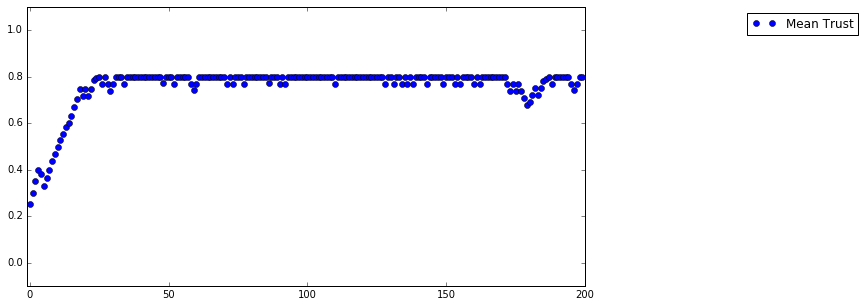

In [33]:
list_of_average_alpha = list()
list_of_percentage_flip = list()
list_of_percentage_good_orders = list()
for i in range(len(all_iterations)):
    list_of_average_alpha.append(np.mean(all_iterations[i]['alpha'].values()))
    list_of_percentage_flip.append(float(Counter(all_iterations[i]['flip_keep'].values())['flip']) / len(Counter(all_iterations[i]['flip_keep']).values()))
    list_of_percentage_good_orders.append(float(Counter(all_iterations[i]['bits'].values())[1]) / len(Counter(all_iterations[i]['bits']).values()))
    
plt.figure(figsize=(10,5))
#plt.plot(range(len(list_of_percentage_flip)), list_of_percentage_flip, 'ro', label = "Flips")
#plt.plot(range(len(list_of_percentage_good_orders)), list_of_percentage_good_orders, 'go', label = "Good orders")
plt.plot(range(len(list_of_average_alpha)), list_of_average_alpha, 'bo', label = "Mean Trust")
plt.legend(bbox_to_anchor=[1.5, 1])
plt.ylim(-0.1,1.1)
plt.xlim(-1, len(list_of_average_alpha))
plt.show()